# Visualizations for MEGA


## Behaviour & Achieved Goal Distribution
Color code the behaviour/achieved goal over the epoch / training iterations.

Similar to Sibling Rivalry paper Figure 3: https://papers.nips.cc/paper/9225-keeping-your-distance-solving-sparse-reward-tasks-using-self-balancing-shaped-rewards.pdf

When running the `train_mega.py` training experiments, make sure to use the command line option `--save-embeddings` to ensure that we are logging the behaviour and achieved goals over the course of training for this visualization. 

Do this for:
1. PointMaze
2. AntMaze

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, glob
%matplotlib inline

## PointMaze

In [43]:
# Copyright (c) 2019, salesforce.com, inc.
# All rights reserved.
# SPDX-License-Identifier: MIT
# For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/MIT

import numpy as np
import matplotlib.pyplot as plt


class CircleMaze:
    def __init__(self):
        self.ring_r = 0.15
        self.stop_t = 0.05
        self.s_angle = 30

        self.mean_s0 = (
            float(np.cos(np.pi * self.s_angle / 180)),
            float(np.sin(np.pi * self.s_angle / 180))
        )
        self.mean_g = (
            float(np.cos(np.pi * (360-self.s_angle) / 180)),
            float(np.sin(np.pi * (360-self.s_angle) / 180))
        )

    def plot(self, ax=None):
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
        rads = np.linspace(self.stop_t * 2 * np.pi, (1 - self.stop_t) * 2 * np.pi)
        xs_i = (1 - self.ring_r) * np.cos(rads)
        ys_i = (1 - self.ring_r) * np.sin(rads)
        xs_o = (1 + self.ring_r) * np.cos(rads)
        ys_o = (1 + self.ring_r) * np.sin(rads)
        ax.plot(xs_i, ys_i, 'k', linewidth=3)
        ax.plot(xs_o, ys_o, 'k', linewidth=3)
        ax.plot([xs_i[0], xs_o[0]], [ys_i[0], ys_o[0]], 'k', linewidth=3)
        ax.plot([xs_i[-1], xs_o[-1]], [ys_i[-1], ys_o[-1]], 'k', linewidth=3)
        lim = 1.1 + self.ring_r
        ax.set_xlim([-lim, lim])
        ax.set_ylim([-lim, lim])

    def sample_start(self):
        STD = 0.1
        return self.move(self.mean_s0, (STD * np.random.randn(), STD * np.random.randn()))

    def sample_goal(self):
        STD = 0.1
        return self.move(self.mean_g, (STD * np.random.randn(), STD * np.random.randn()))

    @staticmethod
    def xy_to_rt(xy):
        x = xy[0]
        y = xy[1]
        r = np.sqrt(x ** 2 + y ** 2)
        t = np.arctan2(y, x) % (2 * np.pi)
        return r, t

    def move(self, coords, action):
        xp, yp = coords
        rp, tp = self.xy_to_rt(coords)

        xy = (coords[0] + action[0], coords[1] + action[1])

        r, t = self.xy_to_rt(xy)
        t = np.clip(t % (2 * np.pi), (0.001 + self.stop_t) * (2 * np.pi), (1 - (0.001 + self.stop_t)) * (2 * np.pi))
        x = np.cos(t) * r
        y = np.sin(t) * r

        if coords is not None:

            if xp > 0:
                if (y < 0) and (yp > 0):
                    t = self.stop_t * 2 * np.pi
                elif (y > 0) and (yp < 0):
                    t = (1 - self.stop_t) * 2 * np.pi
            x = np.cos(t) * r
            y = np.sin(t) * r

        n = 8
        xyi = np.array([xp, yp]).astype(np.float32)
        dxy = (np.array([x, y]).astype(np.float32) - xyi) / n
        new_r = float(rp)
        new_t = float(tp)

        count = 0

        def r_ok(r_):
            return (1 - self.ring_r) <= r_ <= (1 + self.ring_r)

        def t_ok(t_):
            return (self.stop_t * (2 * np.pi)) <= (t_ % (2 * np.pi)) <= ((1 - self.stop_t) * (2 * np.pi))

        while r_ok(new_r) and t_ok(new_t) and count < n:
            xyi += dxy
            new_r, new_t = self.xy_to_rt(xyi)
            count += 1

        r = np.clip(new_r, 1 - self.ring_r + 0.01, 1 + self.ring_r - 0.01)
        t = np.clip(new_t % (2 * np.pi), (0.001 + self.stop_t) * (2 * np.pi), (1 - (0.001 + self.stop_t)) * (2 * np.pi))
        x = np.cos(t) * r
        y = np.sin(t) * r

        return float(x), float(y)


class Maze:
    def __init__(self, *segment_dicts, goal_squares=None, start_squares=None):
        self._segments = {'origin': {'loc': (0.0, 0.0), 'connect': set()}}
        self._locs = set()
        self._locs.add(self._segments['origin']['loc'])
        self._walls = set()
        for direction in ['up', 'down', 'left', 'right']:
            self._walls.add(self._wall_line(self._segments['origin']['loc'], direction))
        self._last_segment = 'origin'
        self.goal_squares = None

        if goal_squares is None:
            self._goal_squares = None
        elif isinstance(goal_squares, str):
            self._goal_squares = [goal_squares.lower()]
        elif isinstance(goal_squares, (tuple, list)):
            self._goal_squares = [gs.lower() for gs in goal_squares]
        else:
            raise TypeError

        if start_squares is None:
            self.start_squares = ['origin']
        elif isinstance(start_squares, str):
            self.start_squares = [start_squares.lower()]
        elif isinstance(start_squares, (tuple, list)):
            self.start_squares = [ss.lower() for ss in start_squares]
        else:
            raise TypeError

        for segment_dict in segment_dicts:
            self._add_segment(**segment_dict)
        self._finalize()

    @staticmethod
    def _wall_line(coord, direction):
        x, y = coord
        if direction == 'up':
            w = [(x - 0.5, x + 0.5), (y + 0.5, y + 0.5)]
        elif direction == 'right':
            w = [(x + 0.5, x + 0.5), (y + 0.5, y - 0.5)]
        elif direction == 'down':
            w = [(x - 0.5, x + 0.5), (y - 0.5, y - 0.5)]
        elif direction == 'left':
            w = [(x - 0.5, x - 0.5), (y - 0.5, y + 0.5)]
        else:
            raise ValueError
        w = tuple([tuple(sorted(line)) for line in w])
        return w

    def _add_segment(self, name, anchor, direction, connect=None, times=1):
        name = str(name).lower()
        original_name = str(name).lower()
        if times > 1:
            assert connect is None
            last_name = str(anchor).lower()
            for time in range(times):
                this_name = original_name + str(time)
                self._add_segment(name=this_name.lower(), anchor=last_name, direction=direction)
                last_name = str(this_name)
            return

        anchor = str(anchor).lower()
        assert anchor in self._segments

        direction = str(direction).lower()

        final_connect = set()

        if connect is not None:
            if isinstance(connect, str):
                connect = str(connect).lower()
                assert connect in ['up', 'down', 'left', 'right']
                final_connect.add(connect)
            elif isinstance(connect, (tuple, list)):
                for connect_direction in connect:
                    connect_direction = str(connect_direction).lower()
                    assert connect_direction in ['up', 'down', 'left', 'right']
                    final_connect.add(connect_direction)

        sx, sy = self._segments[anchor]['loc']
        dx, dy = 0.0, 0.0
        if direction == 'left':
            dx -= 1
            final_connect.add('right')
        elif direction == 'right':
            dx += 1
            final_connect.add('left')
        elif direction == 'up':
            dy += 1
            final_connect.add('down')
        elif direction == 'down':
            dy -= 1
            final_connect.add('up')
        else:
            raise ValueError

        new_loc = (sx + dx, sy + dy)
        assert new_loc not in self._locs

        self._segments[name] = {'loc': new_loc, 'connect': final_connect}
        for direction in ['up', 'down', 'left', 'right']:
            self._walls.add(self._wall_line(new_loc, direction))
        self._locs.add(new_loc)

        self._last_segment = name

    def _finalize(self):
        for segment in self._segments.values():
            for c_dir in list(segment['connect']):
                wall = self._wall_line(segment['loc'], c_dir)
                if wall in self._walls:
                    self._walls.remove(wall)

        if self._goal_squares is None:
            self.goal_squares = [self._last_segment]
        else:
            self.goal_squares = []
            for gs in self._goal_squares:
                assert gs in self._segments
                self.goal_squares.append(gs)

    def plot(self, ax=None):
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
        for x, y in self._walls:
            ax.plot(x, y, 'k-')

    def sample_start(self):
        min_wall_dist = 0.05

        s_square = self.start_squares[np.random.randint(low=0, high=len(self.start_squares))]
        s_square_loc = self._segments[s_square]['loc']

        while True:
            shift = np.random.uniform(low=-0.5, high=0.5, size=(2,))
            loc = s_square_loc + shift
            dist_checker = np.array([min_wall_dist, min_wall_dist]) * np.sign(shift)
            stopped_loc = self.move(loc, dist_checker)
            if float(np.sum(np.abs((loc + dist_checker) - stopped_loc))) == 0.0:
                break
        return loc[0], loc[1]

    def sample_goal(self, min_wall_dist=None):
        if min_wall_dist is None:
            min_wall_dist = 0.1
        else:
            min_wall_dist = min(0.4, max(0.01, min_wall_dist))

        g_square = self.goal_squares[np.random.randint(low=0, high=len(self.goal_squares))]
        g_square_loc = self._segments[g_square]['loc']
        while True:
            shift = np.random.uniform(low=-0.5, high=0.5, size=(2,))
            loc = g_square_loc + shift
            dist_checker = np.array([min_wall_dist, min_wall_dist]) * np.sign(shift)
            stopped_loc = self.move(loc, dist_checker)
            if float(np.sum(np.abs((loc + dist_checker) - stopped_loc))) == 0.0:
                break
        return loc[0], loc[1]

    def move(self, coord_start, coord_delta, depth=None):
        if depth is None:
            depth = 0
        cx, cy = coord_start
        loc_x0 = np.round(cx)
        loc_y0 = np.round(cy)
        #assert (float(loc_x0), float(loc_y0)) in self._locs
        dx, dy = coord_delta
        loc_x1 = np.round(cx + dx)
        loc_y1 = np.round(cy + dy)
        d_loc_x = int(np.abs(loc_x1 - loc_x0))
        d_loc_y = int(np.abs(loc_y1 - loc_y0))
        xs_crossed = [loc_x0 + (np.sign(dx) * (i + 0.5)) for i in range(d_loc_x)]
        ys_crossed = [loc_y0 + (np.sign(dy) * (i + 0.5)) for i in range(d_loc_y)]

        rds = []

        for x in xs_crossed:
            r = (x - cx) / dx
            loc_x = np.round(cx + (0.999 * r * dx))
            loc_y = np.round(cy + (0.999 * r * dy))
            direction = 'right' if dx > 0 else 'left'
            crossed_line = self._wall_line((loc_x, loc_y), direction)
            if crossed_line in self._walls:
                rds.append([r, direction])

        for y in ys_crossed:
            r = (y - cy) / dy
            loc_x = np.round(cx + (0.999 * r * dx))
            loc_y = np.round(cy + (0.999 * r * dy))
            direction = 'up' if dy > 0 else 'down'
            crossed_line = self._wall_line((loc_x, loc_y), direction)
            if crossed_line in self._walls:
                rds.append([r, direction])

        # The wall will only stop the agent in the direction perpendicular to the wall
        if rds:
            rds = sorted(rds)
            r, direction = rds[0]
            if depth < 3:
                new_dx = r * dx
                new_dy = r * dy
                repulsion = float(np.abs(np.random.rand() * 0.01))
                if direction in ['right', 'left']:
                    new_dx -= np.sign(dx) * repulsion
                    partial_coords = cx + new_dx, cy + new_dy
                    remaining_delta = (0.0, (1 - r) * dy)
                else:
                    new_dy -= np.sign(dy) * repulsion
                    partial_coords = cx + new_dx, cy + new_dy
                    remaining_delta = ((1 - r) * dx, 0.0)
                return self.move(partial_coords, remaining_delta, depth+1)
        else:
            r = 1.0

        dx *= r
        dy *= r
        return cx + dx, cy + dy


def make_crazy_maze(size, seed=None):
    np.random.seed(seed)

    deltas = [
        [(-1, 0), 'right'],
        [(1, 0), 'left'],
        [(0, -1), 'up'],
        [(0, 1), 'down'],
    ]

    empty_locs = []
    for x in range(size):
        for y in range(size):
            empty_locs.append((x, y))

    locs = [empty_locs.pop(0)]
    dirs = [None]
    anchors = [None]

    while len(empty_locs) > 0:
        still_empty = []
        np.random.shuffle(empty_locs)
        for empty_x, empty_y in empty_locs:
            found_anchor = False
            np.random.shuffle(deltas)
            for (dx, dy), direction in deltas:
                c = (empty_x + dx, empty_y + dy)
                if c in locs:
                    found_anchor = True
                    locs.append((empty_x, empty_y))
                    dirs.append(direction)
                    anchors.append(c)
                    break
            if not found_anchor:
                still_empty.append((empty_x, empty_y))
        empty_locs = still_empty[:]

    locs = [str(x) + ',' + str(y) for x, y in locs[1:]]
    dirs = dirs[1:]
    anchors = [str(x) + ',' + str(y) for x, y in anchors[1:]]
    anchors = ['origin' if a == '0,0' else a for a in anchors]

    segments = []
    for loc, d, anchor in zip(locs, dirs, anchors):
        segments.append(dict(name=loc, anchor=anchor, direction=d))

    np.random.seed()
    return Maze(*segments, goal_squares='{s},{s}'.format(s=size - 1))


def make_experiment_maze(h, half_w, sz0):
    if h < 2:
        h = 2
    if half_w < 3:
        half_w = 3
    w = 1 + (2*half_w)
    # Create the starting row
    segments = [{'anchor': 'origin', 'direction': 'right', 'name': '0,1'}]
    for w_ in range(1, w-1):
        segments.append({'anchor': '0,{}'.format(w_), 'direction': 'right', 'name': '0,{}'.format(w_+1)})

    # Add each row to create H
    for h_ in range(1, h):
        segments.append({'anchor': '{},{}'.format(h_-1, w-1), 'direction': 'up', 'name': '{},{}'.format(h_, w-1)})

        c = None if h_ == sz0 else 'down'
        for w_ in range(w-2, -1, -1):
            segments.append(
                {'anchor': '{},{}'.format(h_, w_+1), 'direction': 'left', 'connect': c, 'name': '{},{}'.format(h_, w_)}
            )

    return Maze(*segments, goal_squares=['{},{}'.format(h-1, half_w+d) for d in [0]])


def make_hallway_maze(corridor_length):
    corridor_length = int(corridor_length)
    assert corridor_length >= 1

    segments = []
    last = 'origin'
    for x in range(1, corridor_length+1):
        next_name = '0,{}'.format(x)
        segments.append({'anchor': last, 'direction': 'right', 'name': next_name})
        last = str(next_name)

    return Maze(*segments, goal_squares=last)


def make_u_maze(corridor_length):
    corridor_length = int(corridor_length)
    assert corridor_length >= 1

    segments = []
    last = 'origin'
    for x in range(1, corridor_length + 1):
        next_name = '0,{}'.format(x)
        segments.append({'anchor': last, 'direction': 'right', 'name': next_name})
        last = str(next_name)

    assert last == '0,{}'.format(corridor_length)

    up_size = 2

    for x in range(1, up_size+1):
        next_name = '{},{}'.format(x, corridor_length)
        segments.append({'anchor': last, 'direction': 'up', 'name': next_name})
        last = str(next_name)

    assert last == '{},{}'.format(up_size, corridor_length)

    for x in range(1, corridor_length + 1):
        next_name = '{},{}'.format(up_size, corridor_length - x)
        segments.append({'anchor': last, 'direction': 'left', 'name': next_name})
        last = str(next_name)

    assert last == '{},0'.format(up_size)

    return Maze(*segments, goal_squares=last)



mazes_dict = dict()

mazes_dict['circle'] = {'maze': CircleMaze(), 'action_range': 0.25}

segments_a = [
    dict(name='A', anchor='origin', direction='down', times=4),
    dict(name='B', anchor='A3', direction='right', times=4),
    dict(name='C', anchor='B3', direction='up', times=4),
    dict(name='D', anchor='A1', direction='right', times=2),
    dict(name='E', anchor='D1', direction='up', times=2),
]
mazes_dict['square_a'] = {'maze': Maze(*segments_a, goal_squares=['c2', 'c3']), 'action_range': 0.95}

segments_b = [
    dict(name='A', anchor='origin', direction='down', times=4),
    dict(name='B', anchor='A3', direction='right', times=4),
    dict(name='C', anchor='B3', direction='up', times=4),
    dict(name='D', anchor='B1', direction='up', times=4),
]
mazes_dict['square_b'] = {'maze': Maze(*segments_b, goal_squares=['c2', 'c3']), 'action_range': 0.95}

segments_c = [
    dict(name='A', anchor='origin', direction='down', times=4),
    dict(name='B', anchor='A3', direction='right', times=2),
    dict(name='C', anchor='B1', direction='up', times=4),
    dict(name='D', anchor='C3', direction='right', times=2),
    dict(name='E', anchor='D1', direction='down', times=4)
]
mazes_dict['square_c'] = {'maze': Maze(*segments_c, goal_squares=['e2', 'e3']), 'action_range': 0.95}

segments_d = [
    dict(name='TL', anchor='origin', direction='left', times=3),
    dict(name='TLD', anchor='TL2', direction='down', times=3),
    dict(name='TLR', anchor='TLD2', direction='right', times=2),
    dict(name='TLU', anchor='TLR1', direction='up'),
    dict(name='TR', anchor='origin', direction='right', times=3),
    dict(name='TRD', anchor='TR2', direction='down', times=3),
    dict(name='TRL', anchor='TRD2', direction='left', times=2),
    dict(name='TRU', anchor='TRL1', direction='up'),
    dict(name='TD', anchor='origin', direction='down', times=3),
]
mazes_dict['square_d'] = {'maze': Maze(*segments_d, goal_squares=['tlu', 'tlr1', 'tru', 'trl1']), 'action_range': 0.95}

segments_crazy = [
    {'anchor': 'origin', 'direction': 'right', 'name': '1,0'},
     {'anchor': 'origin', 'direction': 'up', 'name': '0,1'},
     {'anchor': '1,0', 'direction': 'right', 'name': '2,0'},
     {'anchor': '0,1', 'direction': 'up', 'name': '0,2'},
     {'anchor': '0,2', 'direction': 'right', 'name': '1,2'},
     {'anchor': '2,0', 'direction': 'up', 'name': '2,1'},
     {'anchor': '1,2', 'direction': 'right', 'name': '2,2'},
     {'anchor': '0,2', 'direction': 'up', 'name': '0,3'},
     {'anchor': '2,1', 'direction': 'right', 'name': '3,1'},
     {'anchor': '1,2', 'direction': 'down', 'name': '1,1'},
     {'anchor': '3,1', 'direction': 'down', 'name': '3,0'},
     {'anchor': '1,2', 'direction': 'up', 'name': '1,3'},
     {'anchor': '3,1', 'direction': 'right', 'name': '4,1'},
     {'anchor': '1,3', 'direction': 'up', 'name': '1,4'},
     {'anchor': '4,1', 'direction': 'right', 'name': '5,1'},
     {'anchor': '4,1', 'direction': 'up', 'name': '4,2'},
     {'anchor': '5,1', 'direction': 'down', 'name': '5,0'},
     {'anchor': '3,0', 'direction': 'right', 'name': '4,0'},
     {'anchor': '1,4', 'direction': 'right', 'name': '2,4'},
     {'anchor': '4,2', 'direction': 'right', 'name': '5,2'},
     {'anchor': '2,4', 'direction': 'right', 'name': '3,4'},
     {'anchor': '3,4', 'direction': 'up', 'name': '3,5'},
     {'anchor': '1,4', 'direction': 'left', 'name': '0,4'},
     {'anchor': '1,4', 'direction': 'up', 'name': '1,5'},
     {'anchor': '2,2', 'direction': 'up', 'name': '2,3'},
     {'anchor': '3,1', 'direction': 'up', 'name': '3,2'},
     {'anchor': '5,0', 'direction': 'right', 'name': '6,0'},
     {'anchor': '3,2', 'direction': 'up', 'name': '3,3'},
     {'anchor': '4,2', 'direction': 'up', 'name': '4,3'},
     {'anchor': '6,0', 'direction': 'up', 'name': '6,1'},
     {'anchor': '6,0', 'direction': 'right', 'name': '7,0'},
     {'anchor': '6,1', 'direction': 'right', 'name': '7,1'},
     {'anchor': '3,4', 'direction': 'right', 'name': '4,4'},
     {'anchor': '1,5', 'direction': 'right', 'name': '2,5'},
     {'anchor': '7,1', 'direction': 'up', 'name': '7,2'},
     {'anchor': '1,5', 'direction': 'up', 'name': '1,6'},
     {'anchor': '4,4', 'direction': 'right', 'name': '5,4'},
     {'anchor': '5,4', 'direction': 'down', 'name': '5,3'},
     {'anchor': '0,4', 'direction': 'up', 'name': '0,5'},
     {'anchor': '7,2', 'direction': 'left', 'name': '6,2'},
     {'anchor': '1,6', 'direction': 'left', 'name': '0,6'},
     {'anchor': '7,0', 'direction': 'right', 'name': '8,0'},
     {'anchor': '7,2', 'direction': 'right', 'name': '8,2'},
     {'anchor': '2,5', 'direction': 'up', 'name': '2,6'},
     {'anchor': '8,0', 'direction': 'up', 'name': '8,1'},
     {'anchor': '3,5', 'direction': 'up', 'name': '3,6'},
     {'anchor': '6,2', 'direction': 'up', 'name': '6,3'},
     {'anchor': '6,3', 'direction': 'right', 'name': '7,3'},
     {'anchor': '3,5', 'direction': 'right', 'name': '4,5'},
     {'anchor': '7,3', 'direction': 'up', 'name': '7,4'},
     {'anchor': '6,3', 'direction': 'up', 'name': '6,4'},
     {'anchor': '6,4', 'direction': 'up', 'name': '6,5'},
     {'anchor': '8,1', 'direction': 'right', 'name': '9,1'},
     {'anchor': '8,2', 'direction': 'right', 'name': '9,2'},
     {'anchor': '2,6', 'direction': 'up', 'name': '2,7'},
     {'anchor': '8,2', 'direction': 'up', 'name': '8,3'},
     {'anchor': '6,5', 'direction': 'left', 'name': '5,5'},
     {'anchor': '5,5', 'direction': 'up', 'name': '5,6'},
     {'anchor': '7,4', 'direction': 'right', 'name': '8,4'},
     {'anchor': '8,4', 'direction': 'right', 'name': '9,4'},
     {'anchor': '0,6', 'direction': 'up', 'name': '0,7'},
     {'anchor': '2,7', 'direction': 'up', 'name': '2,8'},
     {'anchor': '7,4', 'direction': 'up', 'name': '7,5'},
     {'anchor': '9,4', 'direction': 'down', 'name': '9,3'},
     {'anchor': '9,4', 'direction': 'up', 'name': '9,5'},
     {'anchor': '2,7', 'direction': 'left', 'name': '1,7'},
     {'anchor': '4,5', 'direction': 'up', 'name': '4,6'},
     {'anchor': '9,1', 'direction': 'down', 'name': '9,0'},
     {'anchor': '6,5', 'direction': 'up', 'name': '6,6'},
     {'anchor': '3,6', 'direction': 'up', 'name': '3,7'},
     {'anchor': '1,7', 'direction': 'up', 'name': '1,8'},
     {'anchor': '3,7', 'direction': 'right', 'name': '4,7'},
     {'anchor': '2,8', 'direction': 'up', 'name': '2,9'},
     {'anchor': '2,9', 'direction': 'left', 'name': '1,9'},
     {'anchor': '7,5', 'direction': 'up', 'name': '7,6'},
     {'anchor': '1,8', 'direction': 'left', 'name': '0,8'},
     {'anchor': '6,6', 'direction': 'up', 'name': '6,7'},
     {'anchor': '0,8', 'direction': 'up', 'name': '0,9'},
     {'anchor': '7,5', 'direction': 'right', 'name': '8,5'},
     {'anchor': '6,7', 'direction': 'left', 'name': '5,7'},
     {'anchor': '2,9', 'direction': 'right', 'name': '3,9'},
     {'anchor': '3,9', 'direction': 'right', 'name': '4,9'},
     {'anchor': '7,6', 'direction': 'right', 'name': '8,6'},
     {'anchor': '3,7', 'direction': 'up', 'name': '3,8'},
     {'anchor': '9,5', 'direction': 'up', 'name': '9,6'},
     {'anchor': '7,6', 'direction': 'up', 'name': '7,7'},
     {'anchor': '5,7', 'direction': 'up', 'name': '5,8'},
     {'anchor': '3,8', 'direction': 'right', 'name': '4,8'},
     {'anchor': '8,6', 'direction': 'up', 'name': '8,7'},
     {'anchor': '5,8', 'direction': 'right', 'name': '6,8'},
     {'anchor': '7,7', 'direction': 'up', 'name': '7,8'},
     {'anchor': '4,9', 'direction': 'right', 'name': '5,9'},
     {'anchor': '8,7', 'direction': 'right', 'name': '9,7'},
     {'anchor': '7,8', 'direction': 'right', 'name': '8,8'},
     {'anchor': '8,8', 'direction': 'up', 'name': '8,9'},
     {'anchor': '5,9', 'direction': 'right', 'name': '6,9'},
     {'anchor': '6,9', 'direction': 'right', 'name': '7,9'},
     {'anchor': '8,9', 'direction': 'right', 'name': '9,9'},
     {'anchor': '9,9', 'direction': 'down', 'name': '9,8'}
]
mazes_dict['square_large'] = {'maze': Maze(*segments_crazy, goal_squares='9,9'), 'action_range': 0.95}
mazes_dict['nav'] = {'maze': make_hallway_maze(5), 'action_range': 0.15}

In [106]:
mazename = 'nav'

In [45]:
bgs_list = {}
ags_list = {}
rand_ags_list = {}
env = "nav"

bgs_list[env] = {}
ags_list[env] = {}
rand_ags_list[env] = {}

In [46]:
def extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False):
    goals_list = []

    # Skip every other and up to 120k 
    for timestep in timestep_list[::skip_every]:
        if timestep < max_timestep and timestep > min_timestep:
            path = os.path.join(base_path, timestep_dict[timestep], folder_name)
            if os.path.exists(path):
                filename = os.path.join(path, "tensors.tsv")
                data = np.genfromtxt(fname=filename, delimiter="\t", skip_header=0, filling_values=-1)  # change filling_values as req'd to fill in missing values
                # Filter out repeated datapoints
                if filter_unique:
                    data= np.unique(data, axis=0)
                else:
                    # Take last one in each episode
                    data = data[(episode_length-1)::episode_length]
                num_rows = data.shape[0]
                train_step = np.ones((num_rows,1)) * timestep / episode_length / scale
                data = np.append(data, train_step, axis=1)
                goals_list.append(data)

    goals_list = np.concatenate(goals_list, axis=0)
    return goals_list

In [110]:
max_timestep = 30000
min_timestep = 5000
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
# bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

### For OMEGA (i.e. with transition)

In [32]:
bgs_list = {}
ags_list = {}
rand_ags_list = {}

In [33]:
env = "nav"

bgs_list[env] = {}
ags_list[env] = {}
rand_ags_list[env] = {}

In [ ]:
method = "OMEGA"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/harris/proto_env-pointmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-MIN_DENSITY_TRANSITION_ag_cu-minkde_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"

In [ ]:
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]

In [ ]:
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
timestep_list

In [ ]:
# Draw the maze shape
mazes_dict['square_large']['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_bgs_omega_viz.pdf")

In [ ]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_omega_viz.pdf")

In [ ]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_omega_viz.pdf")

## Plot all in one figure with subplots

In [ ]:
num_rows = 1
num_cols = 3
fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(4*num_cols, 4*num_rows))

data_list = [bgs_list[env][method], ags_list[env][method], rand_ags_list[env][method]]
method_name = "OMEGA"
title_list = ["Behaviour Goals ({})".format(method_name),
              "Terminal Achieved Goals ({})".format(method_name),
              "Random Achieved Goals ({})".format(method_name)]

for c in range(num_cols):
    mazes_dict['square_large']['maze'].plot(axs[c])
    
    im = axs[c].scatter(data_list[c][:,0], data_list[c][:,1], c=data_list[c][:,2], alpha=0.4)
    axs[c].set_title(title_list[c])
    axs[c].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)


In [ ]:
# Try plotting both behaviour and achieved goal on the same figure

num_rows = 1
num_cols = 1
fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(4*num_cols, 4*num_rows), dpi=200)

data_list = [bgs_list[env][method], ags_list[env][method], rand_ags_list[env][method]]
method_name = "OMEGA"
title_list = ["Behaviour Goals ({})".format(method_name),
              "Terminal Achieved Goals ({})".format(method_name),
              "Random Achieved Goals ({})".format(method_name)]

mazes_dict['square_large']['maze'].plot(axs)
    
im = axs.scatter(data_list[0][:,0], data_list[0][:,1], c=data_list[0][:,2], alpha=0.4, marker="^", label="Behavioural")
im = axs.scatter(data_list[1][:,0], data_list[1][:,1], c=data_list[1][:,2], alpha=0.4, marker=".", label="Terminal Achieved")
axs.axis('off')


Comment: Looks too busy

### For MEGA (i.e. without transition)

In [48]:
method = "MEGA"

In [101]:
base_path = '/home/vincent/working/thesis/mrl/log/mega/megae_env-navigation2d_alg-DDPG_herfutureactual_2_2_layer-[64, 64]_seed111_tb-MEGA_ag_cu-megae_eexpl0.1_first-True_dg_sc1.0_alpha--1.0'
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [102]:
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

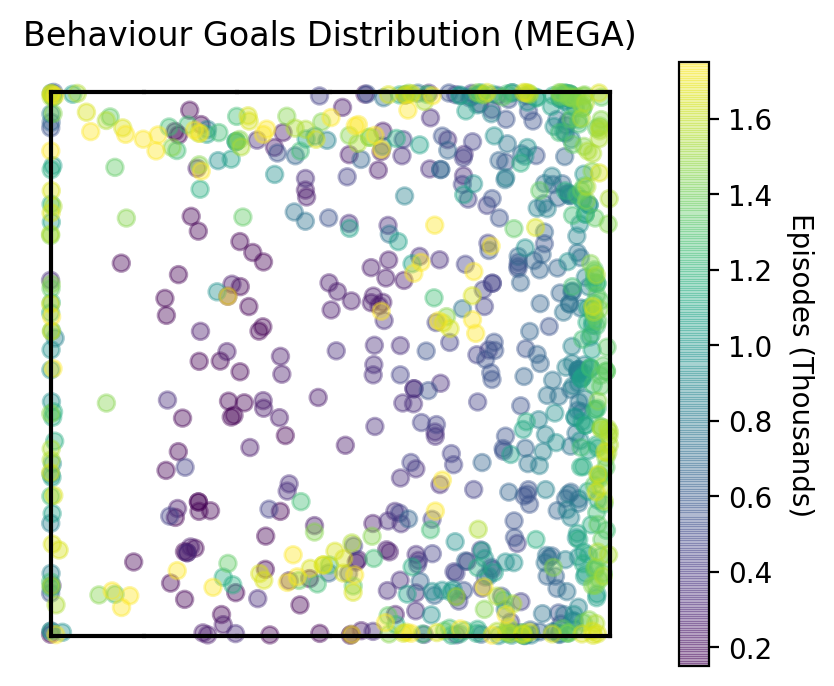

In [107]:
# Draw the maze shape
mazes_dict[mazename]['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
# plt.savefig('.')

In [111]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

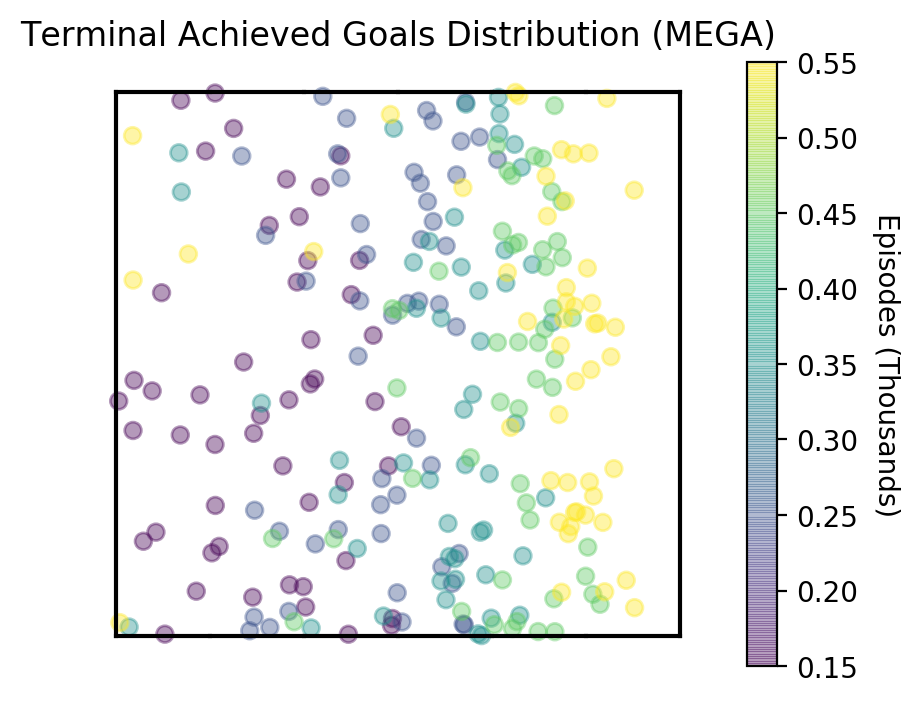

In [112]:
mazes_dict[mazename]['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
# plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_mega_viz.pdf")

In [152]:
a  = np.array([[1, 1], [2, 2], [3, 3]])
b = np.array([[4, 4], [5, 5], [6, 6]])

# np.insert(a,(1,2,2),b, axis=0)

c = np.array([1,1,0,0,0,1])
x = c.nonzero()[0]
y = np.nonzero(c==0)[0]

m = np.empty([6,2])
m[x] = a
m[y] = b
m


array([[1., 1.],
       [2., 2.],
       [4., 4.],
       [5., 5.],
       [6., 6.],
       [3., 3.]])

In [75]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

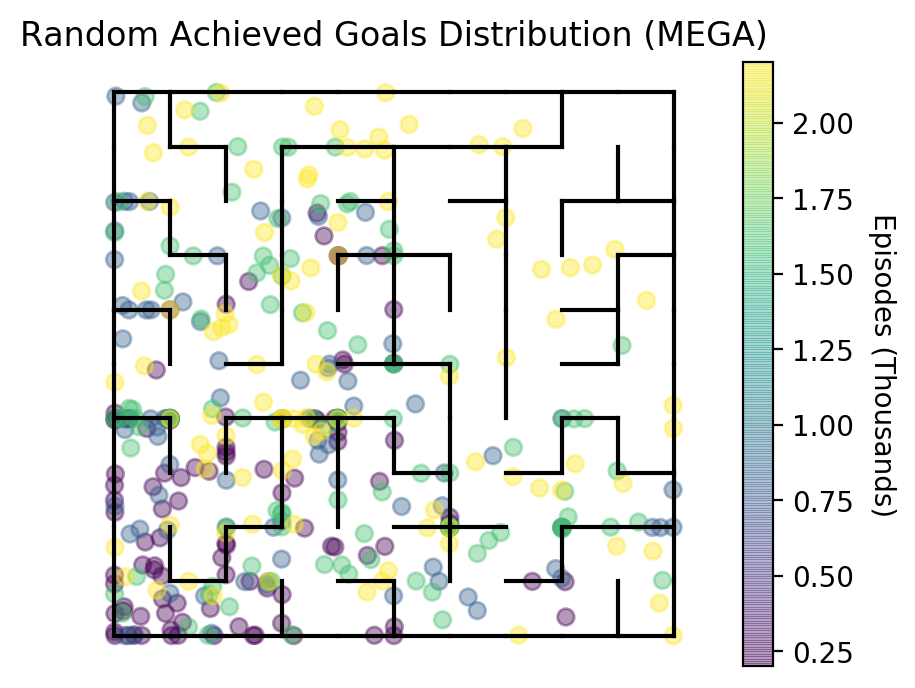

In [76]:
mazes_dict[mazename]['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
# plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_mega_viz.pdf")

## Combine into one plot with shared colorbar

In [ ]:
num_rows = 1
num_cols = 4
fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(4*num_cols, 4*num_rows), dpi=300)

methods = ["OMEGA", "MEGA"]
data_list = []
title_list = []
for method in methods:
    data_list += [bgs_list[env][method], ags_list[env][method]]
    title_list += ["Behaviour Goals ({})".format(method),
              "Terminal Achieved Goals ({})".format(method)]

for c in range(num_cols):
    mazes_dict['square_large']['maze'].plot(axs[c])

    im = axs[c].scatter(data_list[c][:,0], data_list[c][:,1], c=data_list[c][:,2], alpha=0.4)
    axs[c].set_title(title_list[c], fontsize=14)
    axs[c].axis('off')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.subplots_adjust(bottom=0.1, wspace=0.05)

## SkewFit

In [ ]:
method = "SkewFit"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/harris/proto_env-pointmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-SKEWFIT_ag_cu-randkde_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
# Draw the maze shape
mazes_dict['square_large']['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_bgs_skewfit_viz.pdf")

In [ ]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_skewfit_viz.pdf")

In [ ]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_skewfit_viz.pdf")

## MLE (RIG)

In [ ]:
method = "MLE"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/harris/proto_env-pointmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-DISCERN_ag_cu-randkde_eexpl0.1_first-True_dg_sc1.0_alpha-0.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
# Draw the maze shape
mazes_dict['square_large']['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_bgs_mle_viz.pdf")

In [ ]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_mle_viz.pdf")

In [ ]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_mle_viz.pdf")

## GoalGAN

In [ ]:
method = "GoalGAN"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/harris/proto_env-pointmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-GOALGAN_ag_cu-goaldisc_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
# Draw the maze shape
mazes_dict['square_large']['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_bgs_goaldisc_viz.pdf")

In [ ]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_goaldisc_viz.pdf")

In [ ]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_goaldisc_viz.pdf")

## Min Q

In [ ]:
method = "Min Q"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/harris/proto_env-pointmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-MIN_Q_ag_cu-minq_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
# Draw the maze shape
mazes_dict['square_large']['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_bgs_minq_viz.pdf")

In [ ]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_minq_viz.pdf")

In [ ]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_minq_viz.pdf")

## HER

In [ ]:
method = "HER"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/harris/proto_env-pointmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-HER_ag_cu-None_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
# Draw the maze shape
mazes_dict['square_large']['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_bgs_her_viz.pdf")

In [ ]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_her_viz.pdf")

In [ ]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_her_viz.pdf")

## MEGA (Entropy Gain KDE)

In [ ]:
method = "MEGA(EG)"

In [ ]:
base_path = "/scratch/gobi1/harris/icml20_2/proto_env-pointmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-EG_CONDKDE2_ag_cu-entropygainscore_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
# Draw the maze shape
mazes_dict['square_large']['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_bgs_megeg_viz.pdf")

In [ ]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_megeg_viz.pdf")

In [ ]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_megeg_viz.pdf")

## OMEGA (Entropy Gain KDE)

In [ ]:
method = "OMEGA(EG)"

In [ ]:
base_path = "/scratch/gobi1/harris/icml20_2/omega_eg_pointmaze_viz/proto_env-pointmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-EG_CONDKDE2_TRANSITION_ag_cu-entropygainscore_eexpl0.1_first-True_dg_sc1.0_alpha--1.0_vremote"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
folder_name = "last_bgs"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
# Draw the maze shape
mazes_dict['square_large']['maze'].plot()

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_bgs_omegeg_viz.pdf")

In [ ]:
folder_name = "last_ags"
scale = 1000
episode_length = 50
do_filter_unique = False # For last_bgs
skip_every = 2
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_omegeg_viz.pdf")

In [ ]:
folder_name = "rand_ags"
scale = 1000
episode_length = 50
do_filter_unique = True # For last_bgs
skip_every = 2
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=False)

In [ ]:
mazes_dict['square_large']['maze'].plot()
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_rand_ags_omegeg_viz.pdf")

## Combined Plot

In [ ]:
# Behaviour and Achieved goals in one plot
num_rows = 2
num_cols = 7
fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(4*num_cols, 4*num_rows), dpi=300)

methods = ["HER", "MLE", "SkewFit","GoalGAN", "Min Q", "MEGA", "OMEGA"]
method_name_dict = {"HER":"HER", "OMEGA":"OMEGA", "MEGA":"MEGA", "SkewFit":"Diverse", "MLE":"Achieved","GoalGAN":"GoalDisc", "Min Q": "Min Q"}

data_list = []
title_list = []
for r in range(num_rows):
    data_list.append([])
    title_list.append([])
    for method in methods:
        if r == 0:
            data_list[r] += [bgs_list[env][method]]
        elif r == 1:
            data_list[r] += [ags_list[env][method]]
        title_list[r] += [
                  "{} {}".format(method_name_dict[method], "(ours)" if "MEGA" in method else "")]

row_title = [r'Behavioural Goals', r'Final Achieved Goals']
for r in range(num_rows):
    for c in range(num_cols):
        mazes_dict['square_large']['maze'].plot(axs[r,c])

        im = axs[r,c].scatter(data_list[r][c][:,0], data_list[r][c][:,1], c=data_list[r][c][:,2], alpha=0.4)

        if r == 0:
            axs[r][c].set_title(title_list[r][c], fontsize=20, fontweight="bold" if "MEGA" in methods[c] else "normal")
        if c == 0:
            axs[r][c].set_ylabel(row_title[r], fontsize=16, fontweight="bold")
            axs[r][c].axes.get_yaxis().set_ticks([])
        else:
            axs[r][c].get_yaxis().set_visible(False)

        # Hacky way to hide the frames
        axs[r][c].get_xaxis().set_visible(False)
        axs[r][c].spines['bottom'].set_color('white')
        axs[r][c].spines['top'].set_color('white') 
        axs[r][c].spines['right'].set_color('white')
        axs[r][c].spines['left'].set_color('white')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=18, fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.subplots_adjust(bottom=0.1, wspace=0.04, hspace=0.04)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/pointmaze_last_ags_bgs_all_viz.pdf", bbox_inches='tight')

**Note**: The above plot went into the paper

## AntMaze

In [ ]:
def plot_antmaze_template(ax):
    if ax is None:
        fig = plt.figure(dpi=200)
        ax = fig.add_subplot(111, aspect='equal')

    # Frame
    rect = matplotlib.patches.Rectangle((-4,-4), 24, 24, fill=False)
    ax.add_patch(rect) 
    # Wall
    wall = matplotlib.patches.Rectangle((-4,4), 16, 8, fill=True, facecolor='none', edgecolor='black', linewidth=1)
    
    # Cover one of the side
    x = [-4, -4]
    y = [4.1, 11.85]
    ax.plot(x, y, color='white')
    
    ax.add_patch(wall)

In [ ]:
env = "antmaze"
bgs_list = {}
ags_list = {}
rand_ags_list = {}

bgs_list[env] = {}
ags_list[env] = {}
rand_ags_list[env] = {}

In [ ]:
max_timestep = 3000000

## MEGA

In [ ]:
method = "MEGA"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/spitis/proto_env-antmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-MIN_DENSITY_ag_cu-minkde_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
min_timestep = 5000
folder_name = "last_bgs"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)

In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_bgs_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "last_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_last_ags_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "rand_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_rand_ags_{}_viz.pdf".format(method.lower()))

## OMEGA

In [ ]:
method = "OMEGA"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/spitis/proto_env-antmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-MIN_DENSITY_TRANSITION_ag_cu-minkde_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
min_timestep = 5000
folder_name = "last_bgs"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)

In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_bgs_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "last_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_last_ags_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "rand_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_rand_ags_{}_viz.pdf".format(method.lower()))

## SkewFit / Diverse

In [ ]:
method = "Diverse"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/spitis/proto_env-antmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-SKEWFIT_ag_cu-randkde_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
min_timestep = 5000
folder_name = "last_bgs"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)

In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_bgs_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep  = 5000
folder_name = "last_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_last_ags_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "rand_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_rand_ags_{}_viz.pdf".format(method.lower()))

## HER (No Curiosity)

In [ ]:
method = "HER"

In [ ]:
max_timestep

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/harris/proto_env-antmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-HER_ag_cu-None_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
min_timestep = 5000
folder_name = "last_bgs"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)

In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_bgs_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "last_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_last_ags_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "rand_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_rand_ags_{}_viz.pdf".format(method.lower()))

# MLE / Achieved

In [ ]:
method = "Achieved"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/spitis/proto_env-antmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-DISCERN_ag_cu-randkde_eexpl0.1_first-True_dg_sc1.0_alpha-0.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
min_timestep = 5000
folder_name = "last_bgs"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)

In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_bgs_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "last_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_last_ags_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "rand_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_rand_ags_{}_viz.pdf".format(method.lower()))

## GoalDisc

In [ ]:
method = "GoalDisc"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/spitis/proto_env-antmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-GOALDISC_ag_cu-goaldisc_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
min_timestep = 5000
folder_name = "last_bgs"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)

In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_bgs_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "last_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_last_ags_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "rand_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_rand_ags_{}_viz.pdf".format(method.lower()))

## Min-Q

In [ ]:
method = "Min Q"

In [ ]:
base_path = "/scratch/gobi1/spitis/shared/icml20/spitis/proto_env-antmaze_alg-DDPG_herrfaab_1_4_3_1_1_layer-(512, 512, 512)_seed111_tb-MINQ_ag_cu-minq_eexpl0.1_first-True_dg_sc1.0_alpha--1.0"
timestep_list = [folder for folder in os.listdir(base_path) if folder.isdigit()]
timestep_dict = {}
for time in timestep_list:
    timestep_dict[int(time)] = time

timestep_list = [int(t) for t in timestep_list]
timestep_list.sort()

In [ ]:
min_timestep = 5000
folder_name = "last_bgs"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
bgs_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)

In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(bgs_list[env][method][:,0], bgs_list[env][method][:,1], c=bgs_list[env][method][:,2], alpha=0.4)
plt.title("Behaviour Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_bgs_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "last_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(ags_list[env][method][:,0], ags_list[env][method][:,1], c=ags_list[env][method][:,2], alpha=0.4)
plt.title("Terminal Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_last_ags_{}_viz.pdf".format(method.lower()))

In [ ]:
min_timestep = 5000
folder_name = "rand_ags"
scale = 1000
episode_length = 500
do_filter_unique = False # For last_bgs
skip_every = 10
rand_ags_list[env][method] = extract_goals_data(base_path, timestep_dict, timestep_list, min_timestep, max_timestep, folder_name, episode_length, scale, skip_every, filter_unique=do_filter_unique)


In [ ]:
# Draw the antmaze shape
plot_antmaze_template(None)

# Plot color coded points
plt.scatter(rand_ags_list[env][method][:,0], rand_ags_list[env][method][:,1], c=rand_ags_list[env][method][:,2], alpha=0.4)
plt.title("Random Achieved Goals Distribution ({})".format(method))
cbar = plt.colorbar()
plt.axis('off')
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=15)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_rand_ags_{}_viz.pdf".format(method.lower()))

## Plot all in one figure

In [ ]:
# Behaviour and Achieved goals in one plot
# Max timestep = 3000000 (3M)
methods = ["HER", "Achieved", "Diverse","GoalDisc", "Min Q", "MEGA", "OMEGA"]
method_name_dict = {"HER":"HER", "OMEGA":"OMEGA", "MEGA":"MEGA", "Diverse":"Diverse", "Achieved":"Achieved","GoalDisc":"GoalDisc", "Min Q": "Min Q"}

num_rows = 2
num_cols = len(methods)
fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(4*num_cols, 4*num_rows), dpi=300)

data_list = []
title_list = []
for r in range(num_rows):
    data_list.append([])
    title_list.append([])
    for method in methods:
        if r == 0:
            data_list[r] += [bgs_list[env][method]]
        elif r == 1:
            data_list[r] += [ags_list[env][method]]
        title_list[r] += [
                  "{} {}".format(method_name_dict[method], "(ours)" if "MEGA" in method else "")]

row_title = [r'Behavioural Goals', r'Final Achieved Goals']
for r in range(num_rows):
    for c in range(num_cols):
        plot_antmaze_template(axs[r,c])

        im = axs[r,c].scatter(data_list[r][c][:,0], data_list[r][c][:,1], c=data_list[r][c][:,2], alpha=0.4)

        if r == 0:
            axs[r][c].set_title(title_list[r][c], fontsize=20, fontweight="bold" if "MEGA" in methods[c] else "normal")
        if c == 0:
            axs[r][c].set_ylabel(row_title[r], fontsize=16, fontweight="bold")
            axs[r][c].axes.get_yaxis().set_ticks([])
        else:
            axs[r][c].get_yaxis().set_visible(False)

        # Hacky way to hide the frames
        axs[r][c].get_xaxis().set_visible(False)
        axs[r][c].spines['bottom'].set_color('white')
        axs[r][c].spines['top'].set_color('white') 
        axs[r][c].spines['right'].set_color('white')
        axs[r][c].spines['left'].set_color('white')

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Episodes (Thousands)', rotation=270, labelpad=18, fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.subplots_adjust(bottom=0.1, wspace=0.04, hspace=0.04)
plt.savefig("/scratch/gobi1/spitis/shared/icml20/plots/antmaze_last_ags_bgs_all_viz.pdf", bbox_inches='tight')

**Note**: The above plot went into the paper